In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'
model_name = 'distilbert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5896500892651622 	 Validation loss: 0.4224715116670576 	 
  1%|          | 574/57400 [03:00<3:33:38,  4.43it/s]
Epoch 2 	 Training loss: 0.3961655183951614 	 Validation loss: 0.3610962159552817 	 
  2%|▏         | 1148/57400 [05:16<2:56:25,  5.31it/s]
Epoch 3 	 Training loss: 0.3554342261642114 	 Validation loss: 0.34421297023862096 	 
  3%|▎         | 1722/57400 [07:32<3:59:24,  3.88it/s]
Epoch 4 	 Training loss: 0.3345825629834514 	 Validation loss: 0.33412394786285143 	 
  4%|▍         | 2296/57400 [09:48<2:55:39,  5.23it/s]
Epoch 5 	 Training loss: 0.3214428893676618 	 Validation loss: 0.32538142648793883 	 
  5%|▌         | 2870/57400 [12:04<3:31:54,  4.29it/s]
Epoch 6 	 Training loss: 0.3099370503519055 	 Validation loss: 0.3218659940412489 	 
  6%|▌         | 3444/57400 [14:20<3:25:09,  4.38it/s]
Epoch 7 	 Training loss: 0.2990180100298094 	 Validation loss: 0.3138115812661284 	 
  7%|▋         | 4018/57400 [16:36<5:02:42,  2.94it/s]
Epoch 8 	 Training

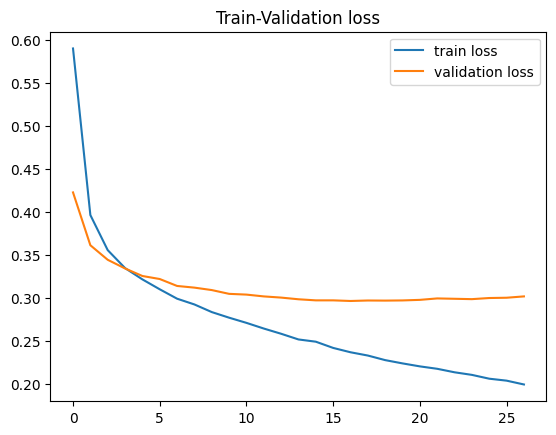

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.815, 'male': 0.859375, 'average': 0.8371875}
precision {'female': 0.8578947368421053, 'male': 0.8168316831683168, 'average': 0.8373632100052111}
f1 {'female': 0.8358974358974358, 'male': 0.8375634517766497, 'average': 0.8367304438370428}
accuracy 0.8367346938775511


Evaluación en el conjunto el conjunto to
recall {'female': 0.6404199475065617, 'male': 0.6934306569343066, 'average': 0.6669253022204342}
precision {'female': 0.6594594594594595, 'male': 0.6753554502369669, 'average': 0.6674074548482132}
f1 {'female': 0.6498002663115846, 'male': 0.6842737094837935, 'average': 0.6670369878976891}
accuracy 0.6679292929292929


Evaluación en el conjunto el conjunto as
recall {'female': 0.706199460916442, 'male': 0.6540404040404041, 'average': 0.6801199324784231}
precision {'female': 0.656641604010025, 'male': 0.7038043478260869, 'average': 0.680222975918056}
f1 {'female': 0.6805194805194805, 'male': 0.6780104712041886, 'average

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5659672764847088 	 Validation loss: 0.42269516445822636 	 
  1%|          | 574/57400 [02:17<2:56:32,  5.36it/s]
Epoch 2 	 Training loss: 0.39274581511365414 	 Validation loss: 0.35727003974429633 	 
  2%|▏         | 1148/57400 [04:35<3:42:23,  4.22it/s]
Epoch 3 	 Training loss: 0.35262926309677783 	 Validation loss: 0.338625869508517 	 
  3%|▎         | 1722/57400 [06:54<3:53:49,  3.97it/s]
Epoch 4 	 Training loss: 0.3327104006650556 	 Validation loss: 0.32912808985023173 	 
  4%|▍         | 2296/57400 [09:11<3:39:40,  4.18it/s]
Epoch 5 	 Training loss: 0.3193779293356872 	 Validation loss: 0.3219238716666981 	 
  5%|▌         | 2870/57400 [11:34<3:56:50,  3.84it/s]
Epoch 6 	 Training loss: 0.3083017856298008 	 Validation loss: 0.31799510752750654 	 
  6%|▌         | 3444/57400 [13:56<3:27:02,  4.34it/s]
Epoch 7 	 Training loss: 0.2987599826129056 	 Validation loss: 0.31225757603928195 	 
  7%|▋         | 4018/57400 [16:15<3:21:07,  4.42it/s]
Epoch 8 	 Train

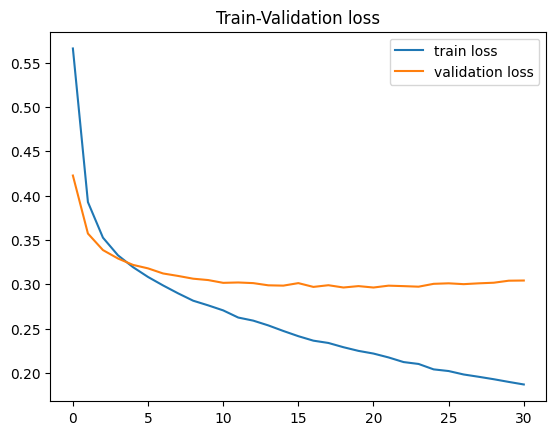

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.859375, 'average': 0.8446875}
precision {'female': 0.8601036269430051, 'male': 0.8291457286432161, 'average': 0.8446246777931106}
f1 {'female': 0.8447837150127224, 'male': 0.843989769820972, 'average': 0.8443867424168472}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6272965879265092, 'male': 0.6934306569343066, 'average': 0.6603636224304079}
precision {'female': 0.6547945205479452, 'male': 0.667447306791569, 'average': 0.6611209136697571}
f1 {'female': 0.6407506702412868, 'male': 0.6801909307875895, 'average': 0.6604708005144382}
accuracy 0.6616161616161617


Evaluación en el conjunto el conjunto as
recall {'female': 0.692722371967655, 'male': 0.6691919191919192, 'average': 0.6809571455797871}
precision {'female': 0.6623711340206185, 'male': 0.6992084432717678, 'average': 0.6807897886461931}
f1 {'female': 0.6772068511198945, 'male': 0.6838709677419356, 'average'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5477864569903251 	 Validation loss: 0.4038316263990887 	 
  1%|          | 574/57400 [02:16<3:40:11,  4.30it/s]
Epoch 2 	 Training loss: 0.38315163152973825 	 Validation loss: 0.35312348301127805 	 
  2%|▏         | 1148/57400 [04:33<3:34:52,  4.36it/s]
Epoch 3 	 Training loss: 0.34869098582853425 	 Validation loss: 0.3391307256484436 	 
  3%|▎         | 1722/57400 [06:49<3:28:42,  4.45it/s]
Epoch 4 	 Training loss: 0.3310624990054124 	 Validation loss: 0.32949423209085305 	 
  4%|▍         | 2296/57400 [09:05<3:45:34,  4.07it/s]
Epoch 5 	 Training loss: 0.31782427591106205 	 Validation loss: 0.32261093996338924 	 
  5%|▌         | 2870/57400 [11:21<2:51:13,  5.31it/s]
Epoch 6 	 Training loss: 0.30775936428158956 	 Validation loss: 0.3179249899872279 	 
  6%|▌         | 3444/57400 [13:37<3:42:03,  4.05it/s]
Epoch 7 	 Training loss: 0.298119954271599 	 Validation loss: 0.31611705407247703 	 
  7%|▋         | 4018/57400 [15:54<3:32:06,  4.19it/s]
Epoch 8 	 Trai

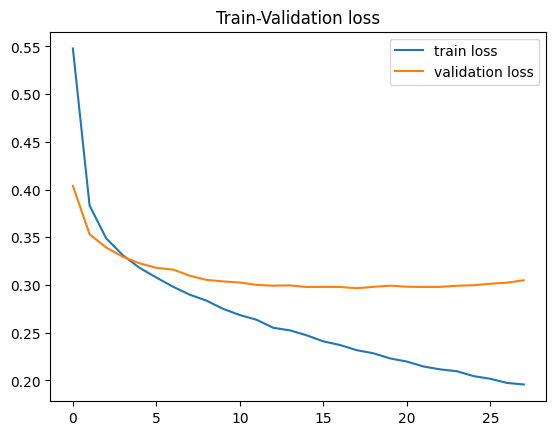

In [21]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [22]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.8515625, 'average': 0.84078125}
precision {'female': 0.8534704370179949, 'male': 0.8278481012658228, 'average': 0.8406592691419088}
f1 {'female': 0.841571609632446, 'male': 0.8395378690629011, 'average': 0.8405547393476736}
accuracy 0.8405612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.6535433070866141, 'male': 0.6861313868613139, 'average': 0.669837346973964}
precision {'female': 0.6587301587301587, 'male': 0.6811594202898551, 'average': 0.6699447895100069}
f1 {'female': 0.6561264822134387, 'male': 0.6836363636363636, 'average': 0.6698814229249012}
accuracy 0.6704545454545454


Evaluación en el conjunto el conjunto as
recall {'female': 0.6954177897574124, 'male': 0.6666666666666666, 'average': 0.6810422282120395}
precision {'female': 0.6615384615384615, 'male': 0.7002652519893899, 'average': 0.6809018567639258}
f1 {'female': 0.6780551905387648, 'male': 0.6830530401034929, 'avera

Resultados finales

In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8405573085338545
f1 etiqueta male: 0.8403636968868409
f1 etiqueta female:  0.840750920180868


TO
Resultado global f1: 0.6657964037790095
f1 etiqueta male: 0.6827003346359155
f1 etiqueta female:  0.6488924729221034


AS
Resultado global f1: 0.6801193335379595
f1 etiqueta male: 0.6816448263498723
f1 etiqueta female:  0.6785938407260467


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8408854166666667
recall etiqueta male: 0.8567708333333334
recall etiqueta female:  0.825


TO
Resultado global recall: 0.6657087572082687
recall etiqueta male: 0.6909975669099757
recall etiqueta female:  0.6404199475065617


AS
Resultado global recall: 0.6807064354234166
recall etiqueta male: 0.6632996632996633
recall etiqueta female:  0.6981132075471698


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8408823856467434
precision etiqueta male: 0.8246085043591186
precision etiqueta female:  0.857156266934368

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6981360632991126 	 Validation loss: 0.6932003770844412 	 
  1%|          | 574/57400 [02:26<4:00:05,  3.94it/s]
Epoch 2 	 Training loss: 0.6974195851473858 	 Validation loss: 0.6929188502036919 	 
  2%|▏         | 1148/57400 [04:53<3:03:23,  5.11it/s]
Epoch 3 	 Training loss: 0.6971552083301212 	 Validation loss: 0.6945761169417429 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:20<3:53:11,  3.98it/s]
Epoch 4 	 Training loss: 0.6969081202865893 	 Validation loss: 0.6926953206628056 	 
  4%|▍         | 2296/57400 [09:47<4:00:17,  3.82it/s]
Epoch 5 	 Training loss: 0.6968501712802395 	 Validation loss: 0.6927048856929198 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:14<3:45:22,  4.03it/s]
Epoch 6 	 Training loss: 0.6959634731663229 	 Validation loss: 0.6948755878513142 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:40<3:54:15,  3.84it/s]
Epoch 7 	 Training loss: 0.6965179941795429 	 Validation loss: 0.693848473

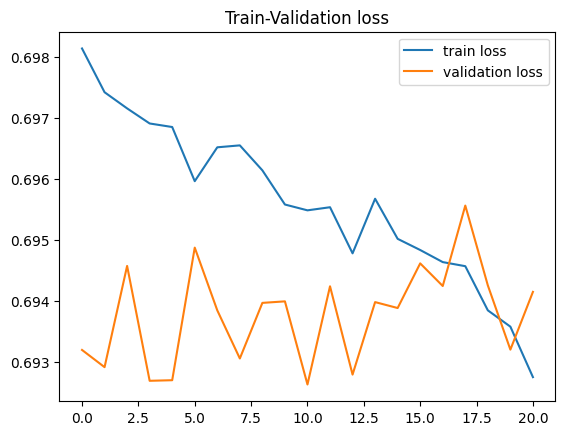

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6075, 'male': 0.3125, 'average': 0.46}
precision {'female': 0.47928994082840237, 'male': 0.4332129963898917, 'average': 0.456251468609147}
f1 {'female': 0.5358324145534731, 'male': 0.3630862329803329, 'average': 0.449459323766903}
accuracy 0.4630102040816326


Evaluación en el conjunto el conjunto to
recall {'female': 0.6666666666666666, 'male': 0.39416058394160586, 'average': 0.5304136253041363}
precision {'female': 0.5049701789264414, 'male': 0.5605536332179931, 'average': 0.5327619060722173}
f1 {'female': 0.574660633484163, 'male': 0.4628571428571428, 'average': 0.5187588881706529}
accuracy 0.5252525252525253


Evaluación en el conjunto el conjunto as
recall {'female': 0.6819407008086253, 'male': 0.3661616161616162, 'average': 0.5240511584851207}
precision {'female': 0.501984126984127, 'male': 0.5513307984790875, 'average': 0.5266574627316072}
f1 {'female': 0.5782857142857143, 'male': 0.4400606980273141, 'average': 0.

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960576580584257 	 Validation loss: 0.6936442750995442 	 
  1%|          | 574/57400 [02:26<4:03:21,  3.89it/s]
Epoch 2 	 Training loss: 0.695401242385758 	 Validation loss: 0.6927762910471125 	 
  2%|▏         | 1148/57400 [04:53<3:14:19,  4.82it/s]
Epoch 3 	 Training loss: 0.6950186985294994 	 Validation loss: 0.693470149727191 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:20<3:11:25,  4.85it/s]
Epoch 4 	 Training loss: 0.6948898799120341 	 Validation loss: 0.692990341428983 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [09:46<3:48:25,  4.02it/s]
Epoch 5 	 Training loss: 0.694696518913794 	 Validation loss: 0.6937854431443295 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [12:13<5:07:39,  2.95it/s]
Epoch 6 	 Training loss: 0.6944350332333236 	 Validation loss: 0.692846459857488 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [14:39<3:52:43,  3.86it/s]
Epoch 7 	 Training loss: 0.6942104502006691 	 Vali

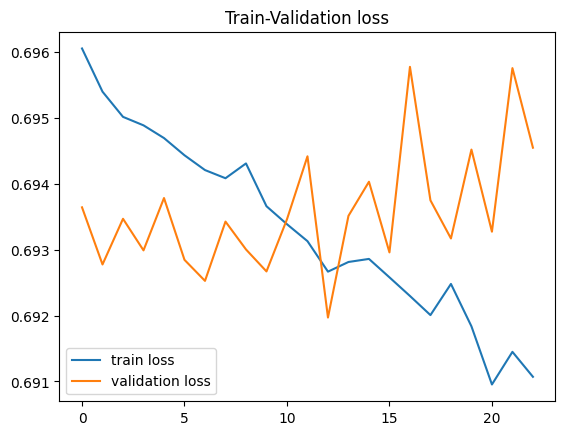

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.84, 'male': 0.2421875, 'average': 0.5410937499999999}
precision {'female': 0.5358851674641149, 'male': 0.5923566878980892, 'average': 0.564120927681102}
f1 {'female': 0.6543330087633885, 'male': 0.3438077634011091, 'average': 0.4990703860822488}
accuracy 0.5471938775510204


Evaluación en el conjunto el conjunto to
recall {'female': 0.8267716535433071, 'male': 0.2141119221411192, 'average': 0.5204417878422132}
precision {'female': 0.493730407523511, 'male': 0.5714285714285714, 'average': 0.5325794894760412}
f1 {'female': 0.6182531894013739, 'male': 0.31150442477876106, 'average': 0.46487880709006746}
accuracy 0.5088383838383839


Evaluación en el conjunto el conjunto as
recall {'female': 0.8571428571428571, 'male': 0.22727272727272727, 'average': 0.5422077922077921}
precision {'female': 0.5096153846153846, 'male': 0.6293706293706294, 'average': 0.569493006993007}
f1 {'female': 0.6391959798994974, 'male': 0.33395176252319

In [31]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6974685891995447 	 Validation loss: 0.6933508858842364 	 
  1%|          | 574/57400 [02:31<4:07:17,  3.83it/s]
Epoch 2 	 Training loss: 0.6956501883496806 	 Validation loss: 0.6948787852869196 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:58<3:57:44,  3.94it/s]
Epoch 3 	 Training loss: 0.6949644385729933 	 Validation loss: 0.6934590541710288 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:25<3:57:26,  3.91it/s]
Epoch 4 	 Training loss: 0.6950501750778239 	 Validation loss: 0.6945421332019871 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:52<4:06:58,  3.72it/s]
Epoch 5 	 Training loss: 0.6948616994797976 	 Validation loss: 0.6926482875468367 	 
  5%|▌         | 2870/57400 [12:19<4:08:32,  3.66it/s]
Epoch 6 	 Training loss: 0.6940689280058033 	 Validation loss: 0.6940653809046341 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:45<3:45:58,  3.98it/s]
Epoch 7 	 Training loss: 0.6940331014606596 	

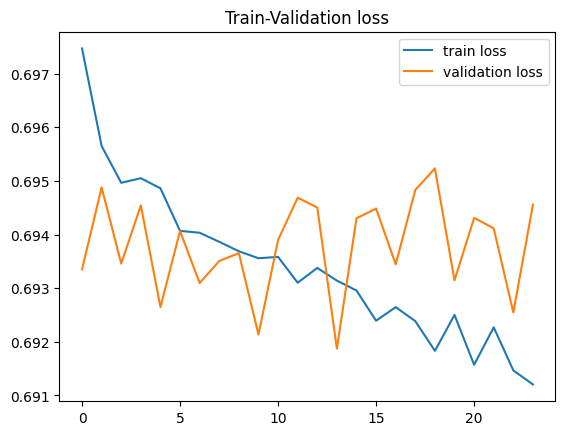

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.665, 'male': 0.4791666666666667, 'average': 0.5720833333333334}
precision {'female': 0.5708154506437768, 'male': 0.5786163522012578, 'average': 0.5747159014225174}
f1 {'female': 0.6143187066974596, 'male': 0.5242165242165242, 'average': 0.5692676154569919}
accuracy 0.5739795918367347


Evaluación en el conjunto el conjunto to
recall {'female': 0.6824146981627297, 'male': 0.44768856447688565, 'average': 0.5650516313198077}
precision {'female': 0.5338809034907598, 'male': 0.6032786885245902, 'average': 0.568579796007675}
f1 {'female': 0.599078341013825, 'male': 0.5139664804469275, 'average': 0.5565224107303762}
accuracy 0.5606060606060606


Evaluación en el conjunto el conjunto as
recall {'female': 0.7196765498652291, 'male': 0.3838383838383838, 'average': 0.5517574668518065}
precision {'female': 0.5225048923679061, 'male': 0.59375, 'average': 0.558127446183953}
f1 {'female': 0.6054421768707483, 'male': 0.4662576687116564,

Resultados finales

In [34]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5059324417687145
f1 etiqueta male: 0.41037017353265537
f1 etiqueta female:  0.6014947100047737


TO
Resultado global f1: 0.5133867019970322
f1 etiqueta male: 0.4294426826942771
f1 etiqueta female:  0.5973307212997873


AS
Resultado global f1: 0.5105323333863536
f1 etiqueta male: 0.4134233764207205
f1 etiqueta female:  0.6076412903519867


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5059324417687145
recall etiqueta male: 0.41037017353265537
recall etiqueta female:  0.6014947100047737


TO
Resultado global recall: 0.5133867019970322
recall etiqueta male: 0.4294426826942771
recall etiqueta female:  0.5973307212997873


AS
Resultado global recall: 0.5105323333863536
recall etiqueta male: 0.4134233764207205
recall etiqueta female:  0.6076412903519867


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5059324417687145
precision etiqueta male: 0.41037017353265537
precision etiqueta female:  

# AS

In [35]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952026143722002 	 Validation loss: 0.6923461819099168 	 
  1%|          | 574/57400 [03:30<4:30:41,  3.50it/s]
Epoch 2 	 Training loss: 0.6935195906237027 	 Validation loss: 0.6926380042302407 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [07:01<4:21:45,  3.58it/s]
Epoch 3 	 Training loss: 0.6918743603736266 	 Validation loss: 0.6907029828782809 	 
  3%|▎         | 1722/57400 [09:41<3:50:28,  4.03it/s]
Epoch 4 	 Training loss: 0.6904652739651111 	 Validation loss: 0.690378538632797 	 
  4%|▍         | 2296/57400 [12:08<3:07:29,  4.90it/s]
Epoch 5 	 Training loss: 0.6887683500811613 	 Validation loss: 0.6926826511399221 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [14:35<3:58:59,  3.80it/s]
Epoch 6 	 Training loss: 0.6879847189898275 	 Validation loss: 0.6921668012263411 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [17:02<3:44:28,  4.01it/s]
Epoch 7 	 Training loss: 0.6875741807841258 	 Validation loss: 0.6910909565

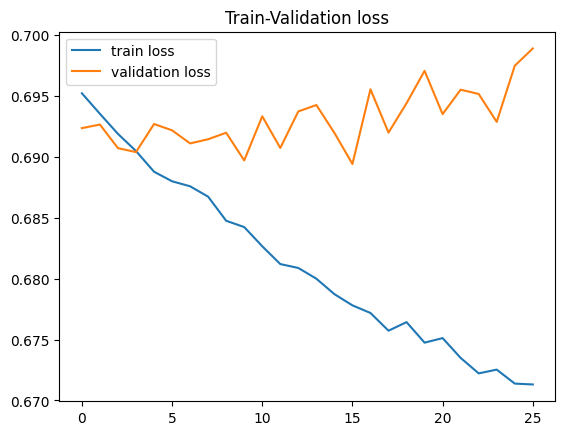

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7275, 'male': 0.46875, 'average': 0.598125}
precision {'female': 0.5878787878787879, 'male': 0.6228373702422145, 'average': 0.6053580790605012}
f1 {'female': 0.6502793296089385, 'male': 0.5349182763744428, 'average': 0.5925988029916907}
accuracy 0.6007653061224489


Evaluación en el conjunto el conjunto to
recall {'female': 0.7322834645669292, 'male': 0.5717761557177615, 'average': 0.6520298101423454}
precision {'female': 0.6131868131868132, 'male': 0.6973293768545994, 'average': 0.6552580950207063}
f1 {'female': 0.667464114832536, 'male': 0.6283422459893047, 'average': 0.6479031804109203}
accuracy 0.648989898989899


Evaluación en el conjunto el conjunto as
recall {'female': 0.8113207547169812, 'male': 0.547979797979798, 'average': 0.6796502763483896}
precision {'female': 0.6270833333333333, 'male': 0.7560975609756098, 'average': 0.6915904471544716}
f1 {'female': 0.7074030552291422, 'male': 0.6354319180087847, 'average'

In [39]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960751910658248 	 Validation loss: 0.691017490322307 	 
  1%|          | 574/57400 [03:23<5:01:00,  3.15it/s]
Epoch 2 	 Training loss: 0.6927877442346633 	 Validation loss: 0.6906542060738903 	 
  2%|▏         | 1148/57400 [06:28<4:58:14,  3.14it/s]
Epoch 3 	 Training loss: 0.6916525033708233 	 Validation loss: 0.691805647591413 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [09:58<5:32:03,  2.79it/s]
Epoch 4 	 Training loss: 0.6902228959346067 	 Validation loss: 0.6920430003586462 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [13:32<5:30:03,  2.78it/s]
Epoch 5 	 Training loss: 0.6888772581512504 	 Validation loss: 0.6895666193153899 	 
  5%|▌         | 2870/57400 [17:07<4:36:55,  3.28it/s]
Epoch 6 	 Training loss: 0.6885706157219119 	 Validation loss: 0.6919895056950844 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [20:42<4:18:48,  3.47it/s]
Epoch 7 	 Training loss: 0.6878952913583364 	 Validation loss: 0.69206068778

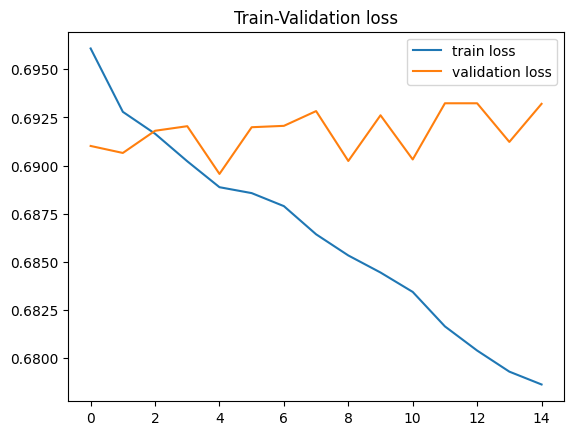

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7225, 'male': 0.4010416666666667, 'average': 0.5617708333333333}
precision {'female': 0.5568400770712909, 'male': 0.5811320754716981, 'average': 0.5689860762714944}
f1 {'female': 0.6289445048966267, 'male': 0.4745762711864407, 'average': 0.5517603880415337}
accuracy 0.5650510204081632


Evaluación en el conjunto el conjunto to
recall {'female': 0.7454068241469817, 'male': 0.36739659367396593, 'average': 0.5564017089104738}
precision {'female': 0.5220588235294118, 'male': 0.6088709677419355, 'average': 0.5654648956356736}
f1 {'female': 0.6140540540540541, 'male': 0.4582701062215478, 'average': 0.536162080137801}
accuracy 0.5492424242424242


Evaluación en el conjunto el conjunto as
recall {'female': 0.7978436657681941, 'male': 0.40404040404040403, 'average': 0.6009420349042991}
precision {'female': 0.556390977443609, 'male': 0.6808510638297872, 'average': 0.6186210206366981}
f1 {'female': 0.6555924695459578, 'male': 0.507

In [42]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6974477385810028 	 Validation loss: 0.6977096705113427 	 
  1%|          | 574/57400 [02:58<3:56:55,  4.00it/s]
Epoch 2 	 Training loss: 0.6983664523849089 	 Validation loss: 0.6972917055679579 	 
  2%|▏         | 1148/57400 [05:57<4:33:19,  3.43it/s]
Epoch 3 	 Training loss: 0.6975228831120069 	 Validation loss: 0.6978286858332359 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [08:55<4:45:31,  3.25it/s]
Epoch 4 	 Training loss: 0.6983040752934246 	 Validation loss: 0.6991000185578556 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [11:52<6:13:11,  2.46it/s]
Epoch 5 	 Training loss: 0.698227791420674 	 Validation loss: 0.6965409486980761 	 
  5%|▌         | 2870/57400 [14:49<3:52:21,  3.91it/s]
Epoch 6 	 Training loss: 0.6987525935995454 	 Validation loss: 0.6976541058491852 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [17:57<4:19:38,  3.46it/s]
Epoch 7 	 Training loss: 0.6981092947908395 	 Validation loss: 0.6973139865

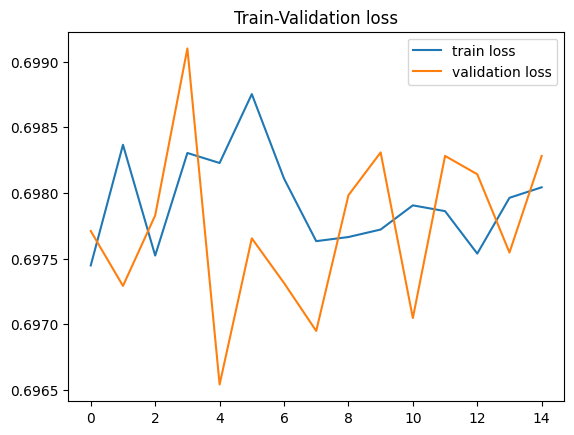

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.0425, 'male': 0.9479166666666666, 'average': 0.4952083333333333}
precision {'female': 0.4594594594594595, 'male': 0.48728246318607765, 'average': 0.47337096132276857}
f1 {'female': 0.07780320366132723, 'male': 0.6436781609195403, 'average': 0.36074068229043377}
accuracy 0.48596938775510207


Evaluación en el conjunto el conjunto to
recall {'female': 0.04461942257217848, 'male': 0.9513381995133819, 'average': 0.4979788110427802}
precision {'female': 0.4594594594594595, 'male': 0.5178807947019868, 'average': 0.4886701270807231}
f1 {'female': 0.08133971291866028, 'male': 0.6706689536878215, 'average': 0.3760043333032409}
accuracy 0.5151515151515151


Evaluación en el conjunto el conjunto as
recall {'female': 0.0673854447439353, 'male': 0.952020202020202, 'average': 0.5097028233820686}
precision {'female': 0.5681818181818182, 'male': 0.5214384508990318, 'average': 0.544810134540425}
f1 {'female': 0.12048192771084337, 'male':

Resultados finales

In [45]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5016999577745527
f1 etiqueta male: 0.5510575694934746
f1 etiqueta female:  0.45234234605563084


TO
Resultado global f1: 0.5200231979506541
f1 etiqueta male: 0.585760435299558
f1 etiqueta female:  0.45428596060175014


AS
Resultado global f1: 0.5499761357995125
f1 etiqueta male: 0.605459787437044
f1 etiqueta female:  0.4944924841619811


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5016999577745527
recall etiqueta male: 0.5510575694934746
recall etiqueta female:  0.45234234605563084


TO
Resultado global recall: 0.5200231979506541
recall etiqueta male: 0.585760435299558
recall etiqueta female:  0.45428596060175014


AS
Resultado global recall: 0.5499761357995125
recall etiqueta male: 0.605459787437044
recall etiqueta female:  0.4944924841619811


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5016999577745527
precision etiqueta male: 0.5510575694934746
precision etiqueta female:  0.4